In [ ]:
!pip install hvplot
!pip install polars
!pip install seaborn
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import polars as pl
import requests


pl.Config.set_tbl_rows(20)


def create_polars_df_from_drive_url(url):
  response = requests.get(url)
  response.raise_for_status()
  df = pl.read_csv(response.content)
  return df

daata = create_polars_df_from_drive_url("https://drive.google.com/uc?id=1RPz-6u4cwwAZ8lAj5sxvj48057yQTwES&export=download")
print(daata)
# print(daata.group_by("label").agg(pl.len()))

# Group by 'label', 'problem_size', 'threads', and 'nproma' and calculate the mean 'millis'
mean_millis_by_nproma = daata.group_by(['label', 'problem_size', 'threads', 'nproma']).agg(
    pl.mean('millis').alias('mean_millis')
)
# print(mean_millis_by_nproma.sort(['label', 'problem_size', 'threads', 'nproma']))

best_configs_for_min_mean_millis = mean_millis_by_nproma.sort('mean_millis').group_by(
    ['label', 'problem_size', 'threads'], maintain_order=True
).first()
# print(best_configs_for_min_mean_millis.sort(['label', 'problem_size', 'threads', 'nproma']))

# Keep rows from 'daata' only if the combination of ['label', 'problem_size', 'threads', 'nproma'] is in 'best_configs_for_min_mean_millis'
daata_best_nproma = daata.join(
    best_configs_for_min_mean_millis,
    on=['label', 'problem_size', 'threads', 'nproma'],
    how='inner'
)

print(daata_best_nproma)

shape: (11_214, 5)
┌────────────────────────────────┬─────────┬──────────────┬────────┬────────┐
│ label                          ┆ threads ┆ problem_size ┆ nproma ┆ millis │
│ ---                            ┆ ---     ┆ ---          ┆ ---    ┆ ---    │
│ str                            ┆ i64     ┆ i64          ┆ i64    ┆ i64    │
╞════════════════════════════════╪═════════╪══════════════╪════════╪════════╡
│ dace/cpu                       ┆ 8       ┆ 65536        ┆ 1      ┆ 1143   │
│ dace/cpu                       ┆ 1       ┆ 32768        ┆ 1      ┆ 3732   │
│ dace/cpu                       ┆ 32      ┆ 32768        ┆ 1      ┆ 152    │
│ dace/cpu                       ┆ 16      ┆ 4096         ┆ 1      ┆ 38     │
│ dace/cpu                       ┆ 8       ┆ 16384        ┆ 1      ┆ 287    │
│ dace/cpu                       ┆ 32      ┆ 8192         ┆ 1      ┆ 41     │
│ dace/cpu                       ┆ 1       ┆ 16384        ┆ 1      ┆ 1864   │
│ dace/cpu                       ┆ 4       ┆ 

In [ ]:
def format_yaxis(value, tick_number):
    """Formats the y-axis ticks."""
    if abs(value) >= 1e9:
        return f'{value / 1e9:.0f}G'
    elif abs(value) >= 1e6:
        return f'{value / 1e6:.0f}M'
    elif abs(value) >= 1e3:
        return f'{value / 1e3:.0f}k'
    elif abs(value) >= 1:
        return f'{value:.0f}'
    else:
        return f'{value:.0f}'

def human_readable_time(mean_millis, _):
    if mean_millis == 0:
        return "0 ms"
    elif mean_millis < 1:
        micros = mean_millis * 1000
        return f"{micros:.0f} µs"
    elif mean_millis < 1000:
        return f"{mean_millis:.0f} ms"
    else:
        seconds = mean_millis / 1000
        if seconds < 10:
            return f"{seconds:.0f} s"
        else:
            return f"{seconds:.0f} s"

def format_duration(mean_millis):
    """
    Converts a duration in milliseconds to a short string representation with units.

    Args:
        mean_millis: The duration in milliseconds.

    Returns:
        A string representing the duration with an appropriate unit suffix (µs, ms, or s).
    """
    if mean_millis == 0:
        return "0 ms"
    elif mean_millis < 1:
        micros = mean_millis * 1000
        return f"{micros:.1f} µs"
    elif mean_millis < 1000:
        return f"{mean_millis:.0f} ms"
    else:
        seconds = mean_millis / 1000
        if seconds < 10:
            return f"{seconds:.2f} s"
        else:
            return f"{seconds:.1f} s"

In [ ]:
# LOG Y Perf Plot All Together

import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
from scipy.stats import t

def construct_performance_plot_table(
    pl_df: pl.DataFrame, baseline_label: str, selected_labels: list, threads: int):

    # Filter the DataFrame
    filtered_data = pl_df.filter(
        (pl.col('label').is_in(selected_labels)) &
        (pl.col('threads') == threads)
    )

    # Group by 'label' and 'problem_size' and calculate mean of 'millis'
    grouped_data = filtered_data.group_by(['label', 'problem_size']).agg(
        pl.mean('millis').alias('mean_millis'),
        pl.std('millis').alias('std_millis'),
        pl.col("millis").count().alias("n")
    ).sort(['problem_size', 'label'])
    grouped_data = grouped_data.with_columns([
        pl.struct(["std_millis", "n"]).map_elements(
            lambda s: t.ppf(0.975, df=s["n"] - 1) * s["std_millis"] / (s["n"] ** 0.5),
            return_dtype=pl.Float64,
        ).alias("margin_of_error")
    ]).with_columns([
        (pl.col("mean_millis") - pl.col("margin_of_error")).alias("ci_lower"),
        (pl.col("mean_millis") + pl.col("margin_of_error")).alias("ci_upper")
    ])

    baseline_data = grouped_data.filter(pl.col('label') == baseline_label).rename({'mean_millis': 'baseline_millis'})

    merged_data = grouped_data.join(
        baseline_data.select(['problem_size', 'baseline_millis']),
        on='problem_size',
        how='left'
    )

    speedup_data = merged_data.with_columns(
        (pl.col('baseline_millis') / pl.col('mean_millis')).alias('speedup')
    ).filter(pl.col('label').is_in(selected_labels))

    return speedup_data

def plot_performance(
    pl_df: pl.DataFrame, baseline_label: str, selected_labels: list,
    legend_mapping: dict, YLIM_LO: float, YLIM_HI: float,
    ax: plt.Axes = None, xlabel: bool = False,
    ylabel_text: str = 'Run Time (ms)', annotation_unit=''):

    assert ax

    # Pick color palette
    color = sns.color_palette("Set1", len(selected_labels))

    # Convert to Pandas DataFrame for Seaborn
    pandas_df = pl_df.to_pandas()

    ax = sns.barplot(
        data=pandas_df,
        x="problem_size",
        y="mean_millis",
        hue="label",
        palette=color,
        errorbar=None,  # we provide our own error bars
        capsize=0.1,
        hue_order=selected_labels,
        ax=ax,
    )
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_text)
    ax.set_ylim(top=YLIM_HI, bottom=YLIM_LO)
    yticks = sorted(ax.get_yticks())
    yticks[0] = YLIM_LO
    ax.set_yticks(yticks)
    ax.set_ylim(top=YLIM_HI, bottom=YLIM_LO)
    ax.yaxis.set_major_formatter(FuncFormatter(human_readable_time))
    handles, labels = ax.get_legend_handles_labels()
    ax.spines['top'].set_visible(False)
    ax.legend(
        handles=handles,
        labels=[legend_mapping.get(label, label) for label in labels],
        loc='upper center', frameon=False, ncol=len(labels),
        bbox_to_anchor=(0.5, 1.25), fontsize=9)
    ax.set_xlabel('Problem size (N_Pt × N_Lvl × N_Blk)' if xlabel else '')
    xtick_labels = ax.get_xticklabels()
    ax.set_xticklabels([f"{int(label.get_text()):,}" for label in xtick_labels])
    ax.margins(x=0.01)  # Very small horizontal margin

    # Instead of using ax.patches directly, loop with clarity:
    for patch in ax.patches:
        x = patch.get_x() + patch.get_width() / 2
        height = patch.get_height()

        # Get bar metadata from the axis tick positions
        # barplot arranges patches in hue-order inside each x tick
        # So we reconstruct the matching info:
        label_index = int(patch.get_facecolor() in color)  # not reliable

        # Better: loop over grouped data again
        for _, row in pandas_df.iterrows():
            if np.isclose(row["mean_millis"], height, atol=1e-3) and np.isclose(x, patch.get_x() + patch.get_width() / 2):
                ci = row["margin_of_error"]
                ax.errorbar(
                    x=x,
                    y=height,
                    yerr=[[ci], [ci]],
                    fmt='none',
                    ecolor='black',
                    capsize=4,
                    linewidth=1,
                )
                break

    # Loop through the bars and annotate them
    for p in ax.patches:
        # Get the height of the bar
        height = p.get_height()

        # Get the x-position of the bar (the center of the bar)
        overflow = height > YLIM_HI * 0.8
        x_pos = p.get_x() + p.get_width() / 2
        y_pos = YLIM_HI/10 if overflow else height

        # Annotate with a line and text
        if annotation_unit:
          s_txt = f"{height/1000.0:.2f}s"
          ms_txt = f"{height:.1f}\nms"
          txt = s_txt if len(s_txt) < len(ms_txt) - 3 else ms_txt
          ax.annotate(
              txt,  # Annotation text (mean_millis)
              xy=(x_pos, y_pos),  # Position at the top of the bar
              xytext=(0, 5),  # Offset for the text (move a bit above the bar)
              textcoords="offset points",
              ha="center",  # Horizontal alignment of the text
              va="bottom",  # Vertical alignment (text goes above the top of the bar)
              fontsize=7,  # Font size of the annotation
              color="white" if overflow else "black",  # Text color
              bbox=dict(facecolor="none", edgecolor="none", boxstyle="round,pad=0.5")  # Box around text
          )

        # if height > YLIM_HI:
        #     fadezone_start = np.log(YLIM_HI) - 0.2 * (np.log(YLIM_HI) - np.log(YLIM_LO))
        #     fadezone_end = np.log(YLIM_HI) + 0.2 * (np.log(YLIM_HI) - np.log(YLIM_LO))
        #     ZONE = fadezone_end - fadezone_start
        #     KZONES = 20
        #     for i in range(KZONES):
        #         fade_start = np.exp(fadezone_start + i * ZONE / KZONES)
        #         fade_end = np.exp(fadezone_start + (i + 1) * ZONE / KZONES)

        #         fade_rect = plt.Rectangle(
        #             (p.get_x(), fade_start),
        #             p.get_width(),
        #             fade_end - fade_start,
        #             transform=ax.transData,
        #             color="white", alpha=(i+1)/KZONES, zorder=10
        #         )
        #         ax.add_patch(fade_rect)


<ipython-input-9-38e9a3ed8e14>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label.get_text()):,}" for label in xtick_labels])
<ipython-input-9-38e9a3ed8e14>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label.get_text()):,}" for label in xtick_labels])
<ipython-input-9-38e9a3ed8e14>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label.get_text()):,}" for label in xtick_labels])


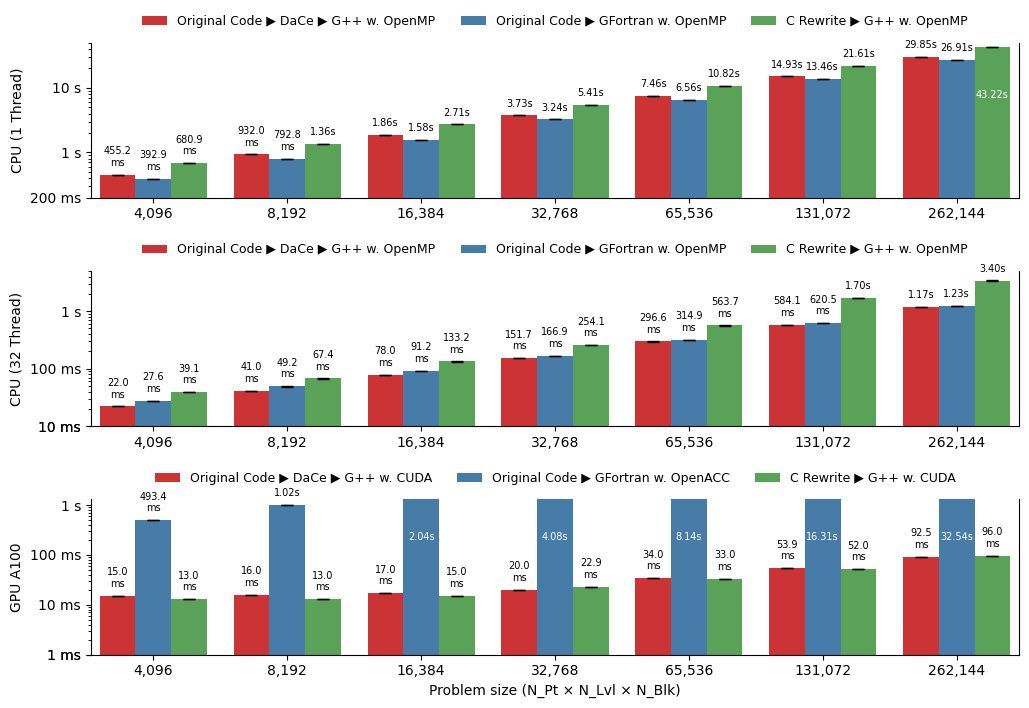

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

num_rows, num_cols = 3, 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols * 7, 2.4 * num_rows))
axes = axes.flatten()

plot_df = construct_performance_plot_table(daata_best_nproma, "original/fortran/cpu", ["dace/cpu", "original/fortran/cpu", "original/c/cpu"], 1)
plot_performance(plot_df, "original/fortran/cpu", ["dace/cpu", "original/fortran/cpu", "original/c/cpu"],
                 legend_mapping={
                    'dace/cpu': 'Original Code ▶ DaCe ▶ G++ w. OpenMP',
                    'original/fortran/cpu': 'Original Code ▶ GFortran w. OpenMP',
                    'original/c/cpu': 'C Rewrite ▶ G++ w. OpenMP'
                 },
                 YLIM_LO=2e2, YLIM_HI=5e4,
                 ax=axes[0], xlabel=False, ylabel_text="CPU (1 Thread)", annotation_unit='s')

plot_df = construct_performance_plot_table(daata_best_nproma, "original/fortran/cpu", ["dace/cpu", "original/fortran/cpu", "original/c/cpu"], 32)
plot_performance(plot_df, "original/fortran/cpu", ["dace/cpu", "original/fortran/cpu", "original/c/cpu"],
                 legend_mapping={
                    'dace/cpu': 'Original Code ▶ DaCe ▶ G++ w. OpenMP',
                    'original/fortran/cpu': 'Original Code ▶ GFortran w. OpenMP',
                    'original/c/cpu': 'C Rewrite ▶ G++ w. OpenMP'
                 },
                 YLIM_LO=10, YLIM_HI=5e3,
                 ax=axes[1], xlabel=False, ylabel_text="CPU (32 Thread)", annotation_unit='ms')

plot_df = construct_performance_plot_table(daata_best_nproma, "original/fortran/openacc", ["dace/gpu_new/a100", "original/fortran/openacc", "original/c/cuda_new/a100"], 1)
plot_performance(plot_df, "original/fortran/openacc", ["dace/gpu_new/a100", "original/fortran/openacc", "original/c/cuda_new/a100"],
                 legend_mapping={
                    'dace/gpu_new/a100': 'Original Code ▶ DaCe ▶ G++ w. CUDA',
                    'original/fortran/openacc': 'Original Code ▶ GFortran w. OpenACC',
                    'original/c/cuda_new/a100': 'C Rewrite ▶ G++ w. CUDA'
                 },
                 YLIM_LO=1, YLIM_HI=1300,
                 ax=axes[2], xlabel=True, ylabel_text="GPU A100", annotation_unit='ms')

plt.tight_layout()
plt.show()

fig.savefig('1-32-gpu.pdf', bbox_inches='tight')
files.download('1-32-gpu.pdf')